# Store-item Sale Forecast


## 1 Problem Statement and Data Analysis

## 1.1 Problem Description

This is part of the [Kaggle competion]( https://www.kaggle.com/c/demand-forecasting-kernels-only/data). 

The training dataset includes 5-year of store-item daily sales data (from 2013 to 2017), the problem is 
to predict 3 months of sales (from January 2018 to March 2018) for 50 different items at 10 different stores.

The evaluation metrics is [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) (symmetric mean absolute percentage error) between forecasts and actual value, which defined as 
$$SMAPE=\frac{1}{n}\sum_{i=0}^n \frac{|y_i-\hat{y_i}|}{\frac{1}{2}(y_i+\hat{y_i})} \cdot 100\%.$$
where $y_i$ is the actual value and $\hat{y_i}$ is the prediction

## Import Packages

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

%matplotlib inline

import datetime

## 1.2 Dataset and Features

### Load and View data 

In [3]:
# Check the data directory via shell command 
import os
print("Working directory: ", os.getcwd())
!dir 

Working directory:  C:\Users\morri\Documents\00Data Science\AWS\FullStackML\demand-forecasting-kernels-only
 Volume in drive C is Windows
 Volume Serial Number is AC2F-8805

 Directory of C:\Users\morri\Documents\00Data Science\AWS\FullStackML\demand-forecasting-kernels-only

2020-06-07  08:38 AM    <DIR>          .
2020-06-07  08:38 AM    <DIR>          ..
2020-06-07  12:29 AM    <DIR>          .ipynb_checkpoints
2020-06-03  02:15 PM    <DIR>          data
2020-06-03  02:02 PM    <DIR>          output
2020-06-07  12:28 AM           273,751 SalesForecast-V2.ipynb
2020-06-07  08:38 AM           136,388 SalesForecast-V3.ipynb
2020-06-06  01:58 PM           135,157 SalesForecast.ipynb
2020-06-02  12:31 PM        69,612,778 train_explore.xlsx
               4 File(s)     70,158,074 bytes
               5 Dir(s)  426,843,783,168 bytes free


In [4]:
# The directory of the input data files is "\data" for windows
df_train = pd.read_csv('data\\train.csv')
df_test = pd.read_csv('data\\test.csv')
sample = pd.read_csv('data\\sample_submission.csv')

In [5]:
print("train columns: ", df_train.columns)
print("train shape: ", df_train.shape)

train columns:  Index(['date', 'store', 'item', 'sales'], dtype='object')
train shape:  (913000, 4)


In [6]:
df_train.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [7]:
new_train = df_train.set_index(['date','store','item'])

In [8]:
new_train.head(3)

,,,sales
date,store,item,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14


In [9]:
print("train columns: ", df_train.columns)
print("train shape: ", df_train.shape)

train columns:  Index(['date', 'store', 'item', 'sales'], dtype='object')
train shape:  (913000, 4)


In [10]:
df_train.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [11]:
print("test columns: ", df_test.columns)
print("test shape", df_test.shape)
df_test.head(3)

test columns:  Index(['id', 'date', 'store', 'item'], dtype='object')
test shape (45000, 4)


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1


In [12]:
# Check the stores, items and date range, and miising data in train and test datasets
print('Entries (Train / Test) : {} / {}'.format(len(df_train), len(df_test)))
s_train, s_test = df_train.store.unique(), df_test.store.unique()
print('Stores (Train / Test) : {} - {} / {} - {}'.format(s_train[0], s_train[-1], s_test[0], s_test[-1]))
i_train, i_test = df_train.item.unique(), df_test.item.unique()
print('Items (Train / Test) : {} - {} / {} - {}'.format(i_train[0], i_train[-1], i_test[0], i_test[-1]))
dates_train, dates_test = df_train.date.unique(), df_test.date.unique()
print('Dates (Train / Test) : {:.10} - {:.10} / {:.10} - {:.10}'.format(dates_train[0], dates_train[-1], dates_test[0], dates_test[-1]))
display(pd.concat([df_train.isnull().sum().rename('Training NaNs'),
                   df_train.isnull().sum().rename('Test NaNs')], axis=1))

Entries (Train / Test) : 913000 / 45000
Stores (Train / Test) : 1 - 10 / 1 - 10
Items (Train / Test) : 1 - 50 / 1 - 50
Dates (Train / Test) : 2013-01-01 - 2017-12-31 / 2018-01-01 - 2018-03-31


,Training NaNs,Test NaNs
date,0,0
store,0,0
item,0,0
sales,0,0


## 1.3 The relationship between the data and the problem being solved.


## Daily Sales Distribution by store by Item

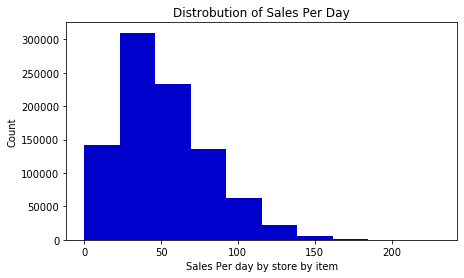

In [13]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(df_train.sales, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day by store by item",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

## Total Sales Per Store

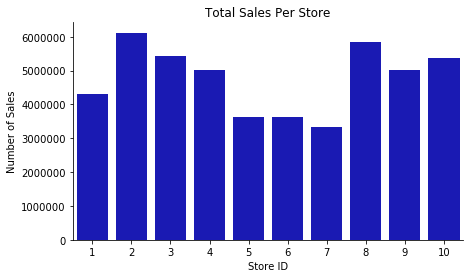

In [14]:
def sales_per_store():
    by_store = df_train.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
    ax.set(xlabel = "Store ID",
           ylabel = "Number of Sales",
           title = "Total Sales Per Store")
    
    sns.despine()
    
sales_per_store()

##  Monthly sales trend and seasonanity


In [15]:
# Check the monthly data
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data


In [16]:
monthly_train= monthly_sales(df_train)
monthly_train.head(3)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382


## Checking seasonanity

In [17]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

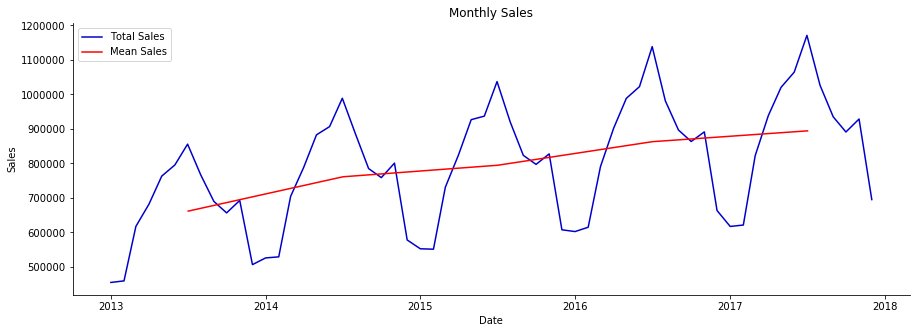

In [18]:
time_plot(monthly_train, 'date', 'sales', 'Monthly Sales')

## 1.4 how update to the dataset will impact the solution
There is seanoality of the trends. New update to the dataset might or might not impact the trends. 

## 1.5 Pros and cons of the available data.

Pros: the avaialble data is simple and is easy for future engineering, i.e combining store and item to create a unique dataset, aggreation by month, by store etc. 

Cons: there is missing additional data such as Holiday schedule , special promotion infomation which might have direct impact to the variation of the sales.   

## 1.6 the additional data resources that would help improve the solution and possible means of collecting it

As mentioned in the last paragraph, additional data info such as work and holiday schedule, special promotion dates and inform and other special events will be helpful. 

Work/Holiday schedule can be obtained from the company directly. 
Special promotion info can be received from sales and marketing or store teams. 


## 2. Feature Engineering

## 2.1 The features and basic characteristics

Naive datetime features: 
* Could aslo add holiday, weekend, work-hours if possible

Lag times or lags, which is to shift the data backward in time as new features:

* n step back in time, n-lag (shift=n) 

Later, we will explore the number of lags as hyperparameter. 

## 2.2 Creating features from raw data

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'],infer_datetime_format=True)
df_train['month'] = df_train['date'].dt.month.astype(str)
df_train['weekday'] = df_train['date'].dt.dayofweek.astype(str)
df_train['year'] = df_train['date'].dt.year.astype(str)
df_train['week_of_year']  = df_train.date.dt.weekofyear.astype(str)

In [ ]:
df_train.head()

In [ ]:
df_test['date'] = pd.to_datetime(df_test['date'],infer_datetime_format=True)
df_test['month'] = df_test['date'].dt.month.astype(str)
df_test['weekday'] = df_test['date'].dt.dayofweek.astype(str)
df_test['year'] = df_test['date'].dt.year.astype(str)
df_test['week_of_year']  = df_test.date.dt.weekofyear.astype(str)
df_test.tail()

## Lag times

In [19]:
class LagTimes(BaseEstimator,TransformerMixin):
    
    def __init__(self,sales,groupbyStore,groupbyItem,numLags,dropna=False):
        
        self.sales = sales
        self.groupbyStore = groupbyStore
        self.groupbyItem = groupbyItem
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Day_Ago'+"_"+self.sales] = tmp.groupby([self.groupbyStore,self.groupbyItem])[self.sales].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

## Check new features for 7-step

In [20]:
steps = [('7_step',LagTimes('sales','store','item',7,dropna=True))]
lag_7 = Pipeline(steps).fit_transform(df_train)

In [21]:
lag_7.head(10)

,date,store,item,sales,1_Day_Ago_sales,2_Day_Ago_sales,3_Day_Ago_sales,4_Day_Ago_sales,5_Day_Ago_sales,6_Day_Ago_sales,7_Day_Ago_sales
0,2013-01-08,1,1,9,10.0,12.0,10.0,13.0,14.0,11.0,13.0
1,2013-01-09,1,1,12,9.0,10.0,12.0,10.0,13.0,14.0,11.0
2,2013-01-10,1,1,9,12.0,9.0,10.0,12.0,10.0,13.0,14.0
3,2013-01-11,1,1,9,9.0,12.0,9.0,10.0,12.0,10.0,13.0
4,2013-01-12,1,1,7,9.0,9.0,12.0,9.0,10.0,12.0,10.0
5,2013-01-13,1,1,10,7.0,9.0,9.0,12.0,9.0,10.0,12.0
6,2013-01-14,1,1,12,10.0,7.0,9.0,9.0,12.0,9.0,10.0
7,2013-01-15,1,1,5,12.0,10.0,7.0,9.0,9.0,12.0,9.0
8,2013-01-16,1,1,7,5.0,12.0,10.0,7.0,9.0,9.0,12.0
9,2013-01-17,1,1,16,7.0,5.0,12.0,10.0,7.0,9.0,9.0



## 2.3 the statistics of the features after feature engineering

In [ ]:
# Convert the type of 'store' and 'item' as string. 
lag_7['store']=lag_7['store'].astype(str)
lag_7['item']=lag_7['item'].astype(str)
lag_7.describe(include='all')

In [ ]:
# Convert the type of 'store' and 'item' as string. 
df_train['store']=df_train['store'].astype(str)
df_train['item']=df_train['item'].astype(str)

In [ ]:
df_train.describe(include='all')

In [ ]:
# Convert the type of 'store' and 'item' as string. 
df_test['store']=df_test['store'].astype(str)
df_test['item']=df_test['item'].astype(str)

In [ ]:
df_test.describe(include='all')

## 3. ML Algorithm Tuning



## Training, validation split for time series
Based on [Forward Chaining/K-fold validation methods for time series](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from itertools import chain

def cvTimeSeriesSplit(X,n_splits=5):

    tscv = TimeSeriesSplit(n_splits,max_train_size=None)
    for train_index, test_index in tscv.split(X.date.unique()):
        X_train_dates, X_test_dates = X.date.unique()[train_index], X.date.unique()[test_index]
        train = X.loc[X.date.isin(X_train_dates)].set_index(['date','store','item'])
        val = X.loc[X.date.isin(X_test_dates)].set_index(['date','store','item'])    
        X_train, X_test = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
        y_train, y_test = train['sales'].values, val['sales'].values
    
        yield X_train, X_test, y_train, y_test    

In [68]:
from sklearn.model_selection import TimeSeriesSplit
from itertools import chain

class cvTimeSeriesSplit(BaseEstimator,TransformerMixin):

    def __init__(self,n_splits,max_train_size=None,dropna=True):

        self.n_splits = n_splits
        self.max_train_size = max_train_size
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self    
        
    def _cvsplit_(self,X):
        
        tscv = TimeSeriesSplit(self.n_splits,self.max_train_size)
        
        for train_index, test_index in tscv.split(self.X.date.unique()):
            
            X_train_dates, X_test_dates = self.X.date.unique()[train_index], self.X.date.unique()[test_index]
            
            train = self.X.loc[self.X.date.isin(X_train_dates)].set_index(['date','store','item'])
            val = self.X.loc[self.X.date.isin(X_test_dates)].set_index(['date','store','item'])    
            
            X_train, X_test = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
            y_train, y_test = train['sales'].values, val['sales'].values
    
            yield X_train, X_test, y_train, y_test
        
    def transform(self,X):
        cvsplit = self._cvsplit_(X)
        return chain(cvsplit)

In [92]:
steps = [('cv',cvTimeSeriesSplit(n_splits=5))]
cv = Pipeline(steps).fit_transform()

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [70]:
for indx, fold in enumerate(cv):
    X_train, X_test, y_train, y_test = fold
    print(str(indx)+'_fold:')
    print('# of train = ',len(X_train))
    print('# of test = ', len(X_test))

0_fold:
# of train =  152000
# of test =  151500
1_fold:
# of train =  303500
# of test =  151500
2_fold:
# of train =  455000
# of test =  151500
3_fold:
# of train =  606500
# of test =  151500
4_fold:
# of train =  758000
# of test =  151500


## Metrics : SMAPE

In [23]:
# Define SMAPE metrics
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)

## 3.0 Base Model: 
Predicted sale is equal to the sales in previous day.
## Baseline Estimator

In [71]:
class BaseEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume predicted sales is equal to the one in previous day
            Input: 
                    predCol: 1_Day_Ago_sales
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)  # smape, np.sqrt(mean_squared_log_error(y, prediction))
        return error

## Base Model

In [21]:
tscv = TimeSeriesSplit(n_splits=10,max_train_size=None)

In [22]:
base_model = BaseEstimator('1_Day_Ago_sales')
errors = []
fold = 1
for train_index, test_index in tscv.split(lag_7.date.unique()):
    X_train_dates, X_test_dates = lag_7.date.unique()[train_index], lag_7.date.unique()[test_index]
    train = lag_7.loc[lag_7.date.isin(X_train_dates)]
    val = lag_7.loc[lag_7.date.isin(X_test_dates)]    
    X_train, X_test = train.drop(['sales'], axis=1), val.drop(['sales'], axis=1)
    y_train, y_test = train['sales'].values, val['sales'].values
    error = base_model.score(X_test,y_test,smape)
    errors.append(error)
    print("Fold: {}, Error(smape): {:.3f}".format(fold,error))
    fold = fold+1
    
print('Total Error {:.3f}'.format(np.mean(errors)))    

Fold: 1, Error(smape): 22.258
Fold: 2, Error(smape): 23.748
Fold: 3, Error(smape): 21.109
Fold: 4, Error(smape): 23.586
Fold: 5, Error(smape): 20.678
Fold: 6, Error(smape): 22.790
Fold: 7, Error(smape): 20.562
Fold: 8, Error(smape): 21.840
Fold: 9, Error(smape): 20.919
Fold: 10, Error(smape): 20.794
Total Error 21.828


In [74]:
steps = [('cv',cvTimeSeriesSplit(n_splits=5))]
cv = Pipeline(steps).fit_transform(lag_7)

In [75]:
base_model = BaseEstimator('1_Day_Ago_sales')
errors = []
for indx, fold in enumerate(cv):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,smape)
    errors.append(error)
    print("Fold: {}, Error(smape): {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))   

Fold: 0, Error(smape): 22.595
Fold: 1, Error(smape): 22.522
Fold: 2, Error(smape): 21.916
Fold: 3, Error(smape): 21.368
Fold: 4, Error(smape): 20.629
Total Error 21.806


## 3.1 Time Series Regression

In [80]:
class TimeSeriesRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx, fold in enumerate(self.cv):
            X_train, X_test, y_train, y_test = fold
            print(X_train)
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    

    def score(self,X,y=None):


        errors = []
        for indx, fold in enumerate(self.cv):
            X_train, X_test, y_train, y_test = fold            
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

## Linear Regression Model

In [86]:
steps = [('cv',cvTimeSeriesSplit(n_splits=6))]
cv = Pipeline(steps).fit_transform(lag_7)

In [87]:
model1 = LinearRegression()

In [89]:
steps = [('7_step',LagTimes('sales','store','item',7,dropna=True)),
         ('cv',cvTimeSeriesSplit(n_splits=5)),
        ('predic_1',TimeSeriesRegressor(model=model1,cv=cv,scoring=smape,verbosity=True))]
lag_7_p = Pipeline(steps).fit(df_train)

In [90]:
Model_1_Error = lag_7_p.score(df_train)

Fold: 0, Error: 17.0145
Fold: 1, Error: 16.2834
Fold: 2, Error: 14.8183
Fold: 3, Error: 15.6813
Fold: 4, Error: 15.8783
Fold: 5, Error: 14.5301
Total Error 15.7010


## Random Forest Regression Model

In [55]:
cv = chain(cvTimeSeriesSplit(lag_7,n_splits=10))

In [56]:
model2 = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

In [57]:
steps = [('7_step',LagTimes('sales','store','item',7,dropna=True)),
        ('predic_2',TimeSeriesRegressor(model=model2,cv=cv,scoring=smape))]
lag_7_p = Pipeline(steps).fit(df_train)

In [ ]:
Model_2_Error = lag_7_p.score(df_train)

Fold: 0, Error: 15.9639
Fold: 1, Error: 16.5669
Fold: 2, Error: 14.0864
Fold: 3, Error: 16.5871
Fold: 4, Error: 13.5437
Fold: 5, Error: 16.1622
Fold: 6, Error: 13.2296


## 3.2 Other Regresion Models : Random Forest Regression, XGBoost

## 3.3 Regression Models with different feature engineering


## 4. Testing the AI Service

## 4.1 Report the test accuracy/RMSE on the test dataset.

## 4.2 Report the KMAPE metrics on the test dataset

## 4.3 Add noise to the features of the test dataset and report the sensitivity of the algorithm to noise on different features.